# Classification Models for Healthcare Frauds
## Deployment

### SeungHeon Han

In [2]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import copy
from collections import Counter
from numpy import where
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import random
import itertools
import xgboost as xgb
from xgboost import XGBClassifier
from interpret.perf import ROC  
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn.pipeline import Pipeline
import os              # for directory and file manipulation
import numpy as np     # for basic array manipulation
import pandas as pd    # for dataframe manipulation
import datetime        # for timestamp
from sklearn.metrics import accuracy_score, f1_score, log_loss, mean_squared_error, roc_auc_score, roc_curve


# global constants 
ROUND = 3              # generally, insane precision is not needed 

# set global random seed for better reproducibility
SEED = 1234
seed = 1234
np.random.seed(SEED)
NTHREAD = 4

import warnings
warnings.filterwarnings('ignore')

In [3]:
# import the cleaned dataset 

partB = pd.read_csv("processed_partB.csv")

In [4]:
partB = partB.drop("Avg_Mdcr_Stdzd_Amt", axis=1)
partB.head()

,NPI,Type,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Fraud
0,1679548440,Dermatology,O,25,46.0,46,281.000000,128.275435,100.793043,0
1,1184730848,Podiatry,O,15,19.0,19,18.962105,18.571579,13.215263,0
2,1700097557,Diagnostic Radiology,F,32,32.0,32,27.000000,9.387187,7.243750,0
3,1659528339,Mass Immunizer Roster Biller,O,112,114.0,114,4.940614,4.366404,4.366404,0
4,1982966685,Family Practice,O,112,114.0,114,35.000000,25.290000,25.290000,0


### Ratio of Fraud and Non-fraud classes 

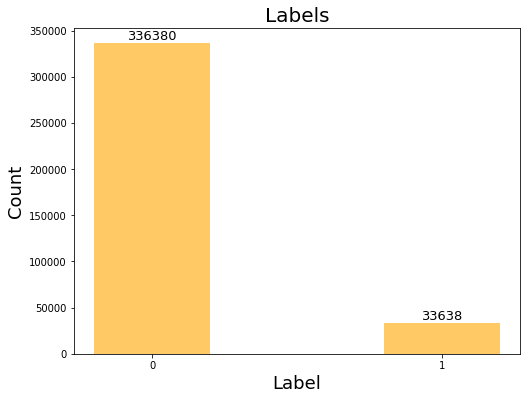

In [5]:
fig = plt.figure(figsize=(8, 6))

# Plot the bar graph
Y_fraud = list(partB["Fraud"].value_counts())
X_fraud = ["0", "1"]

plot = plt.bar(X_fraud, Y_fraud, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Labels", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
 
# Display the graph on the screen
plt.show()

In [6]:
ratio = partB["Fraud"].value_counts(normalize = True) 
print("Non-Fraud: ", round(ratio[0]*100, 2), "%")
print("Fraud: ", round(ratio[1]*100, 2), "%")

Non-Fraud:  90.91 %
Fraud:  9.09 %


### One-Hot Encoding

In [7]:
# One-Hot Encoding 

# Convert the Fraud variable to object datatype
partB["Fraud"] = partB["Fraud"].astype(object)

# Encoding
encoded_partB = pd.get_dummies(partB, drop_first = True)

# Rename some of the changed variable names
encoded_partB.rename(columns = {"Fraud_1":"Fraud", "Place_Of_Srvc_O":"Place_Of_Srvc"}, inplace = True)

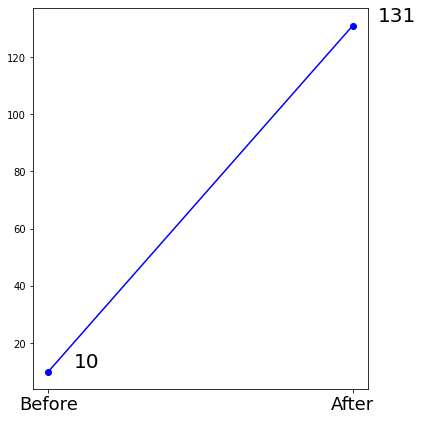

In [8]:
# Feature size of the encoded dataset 

fig, ax = plt.subplots(figsize=(6,7))

xs = ["Before", "After"]
ys = [len(partB.columns), len(encoded_partB.columns)]
ax.plot(xs, ys, "bo-")

for x,y in zip(xs, ys):
    label = "{:d}".format(y)
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(25,4), 
                 ha='left',
                fontsize = 20) 
    
ax.set_xticklabels(xs, fontsize=18)

plt.show()

### Data Spliting

In [9]:
# Assign X and y features

X_var = list(encoded_partB.columns)

for var in ["NPI","Fraud"]:
    X_var.remove(var)

y_var = "Fraud"

In [10]:
# Split the whole dataset into train and test dataset
# Using a stratified random sampling so that the Fraud-class (1) data are evenly split into train & test sets
x_train, x_test, y_train, y_test = train_test_split(encoded_partB[X_var], 
                                                    encoded_partB[y_var], 
                                                    test_size=0.1, 
                                                    stratify=encoded_partB["Fraud"],
                                                    random_state=SEED)

# Also concatenate the split x & y dataframes 
tr_df = pd.concat([x_train, y_train], axis = 1)
te_df = pd.concat([x_test, y_test], axis = 1)

In [11]:
# Calculate the odds ratio of Fraud & Non-fraud labels for train & test sets

train_0 = len(tr_df[tr_df["Fraud"] == 0])
train_1 = len(tr_df[tr_df["Fraud"] == 1])

test_0 = len(te_df[te_df["Fraud"] == 0])
test_1 = len(te_df[te_df["Fraud"] == 1])

split_df = pd.DataFrame({"x_axis":["Train", "Test"], 
                         "Ratio":[train_1/train_0, test_1/test_0]})

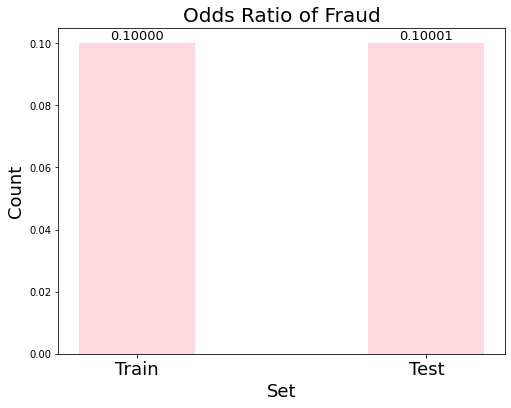

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

# Plot the bar graph
plot = plt.bar(split_df["x_axis"], split_df["Ratio"],
               width = 0.4,
              color = "pink",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%.5f' % height, ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Odds Ratio of Fraud", fontsize = 20)
plt.xlabel("Set", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

ax.set_xticklabels(split_df["x_axis"], fontsize=18)

# Display the graph on the screen
plt.show()

### -----------------SMOTE---------------------

In [13]:
tr_df.head()

,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Type_Advanced Heart Failure and Transplant Cardiology,Type_All Other Suppliers,Type_Allergy/ Immunology,Type_Allergy/Immunology,...,Type_Thoracic Surgery,Type_Undefined Physician type,Type_Undersea and Hyperbaric Medicine,Type_Unknown Physician Specialty Code,Type_Unknown Supplier/Provider,Type_Unknown Supplier/Provider Specialty,Type_Urology,Type_Vascular Surgery,Place_Of_Srvc,Fraud
348797,12,12.0,12,66.000000,30.146667,24.017500,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
33489,32,51.0,51,140.000000,53.551373,38.991765,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
70149,22,69.0,69,100.000000,69.400725,53.272464,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
151709,40,50.0,50,30.000000,15.430000,15.430000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
84786,61,62.0,62,213.629032,120.259032,65.797581,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Scatter Plot of The Imbalanced Data

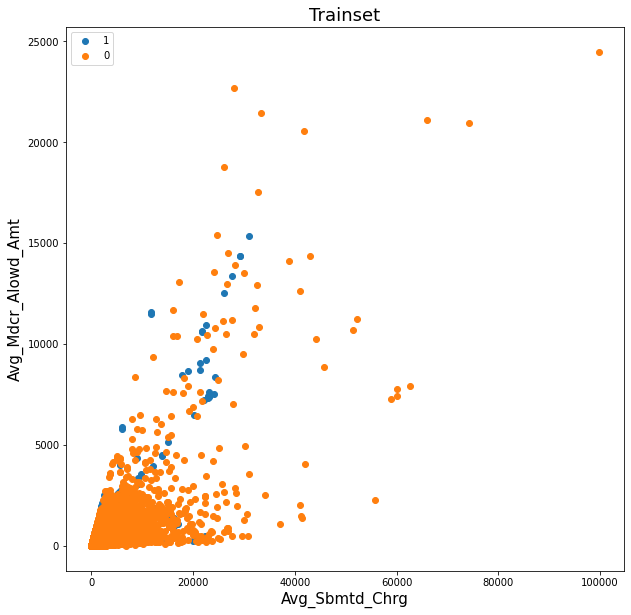

In [14]:
# scatter plot of the imbalanced data
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_df[y_var])
for label, _ in counter.items():
    row_ix = where(tr_df[y_var] == label)[0]
    plt.scatter(tr_df[X_var].iloc[row_ix, 3], 
                tr_df[X_var].iloc[row_ix, 4], 
                label=str(label))

plt.title("Trainset", fontsize = 18)
plt.xlabel("Avg_Sbmtd_Chrg", fontsize = 15)
plt.ylabel("Avg_Mdcr_Alowd_Amt", fontsize = 15)
plt.legend()
plt.show()

### Over-Sampling the random_undersampled imbalnaced data through SMOTE

In [15]:
from imblearn.over_sampling import SMOTE

oversample = over_sampling.SMOTE(sampling_strategy = 0.5, random_state=SEED)
tr_X, tr_y = oversample.fit_resample(x_train, y_train)

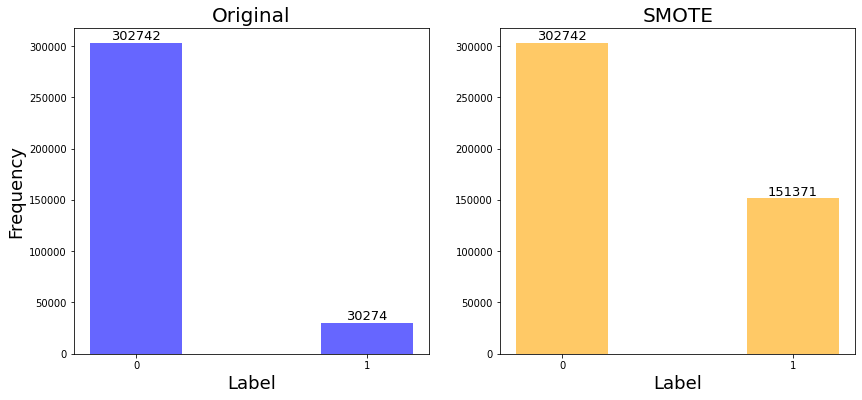

In [16]:
plt.figure(figsize=(14, 6))
plt.subplot(121)

# Plot the bar graph for the original train
Y_fraud = list(y_train.value_counts())
Labels = ["0", "1"]

plot = plt.bar(Labels, Y_fraud, 
               width = 0.4,
              color = "blue",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("Original", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)


plt.subplot(122)

# Plot the bar graph for the over-sampled train
Y_fraud_smote = list(tr_y.value_counts())

plot_smote = plt.bar(Labels, Y_fraud_smote, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot_smote:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("SMOTE", fontsize = 20)
plt.xlabel("Label", fontsize = 18)

# Display the graph on the screen
plt.show()

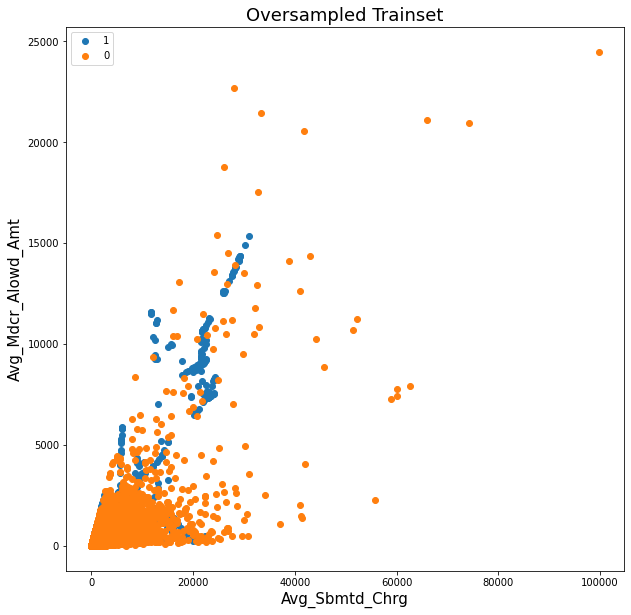

In [17]:
# scatter plot of the data transformed by SMOTE 
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_y)
for label, _ in counter.items():
    row_ix = where(tr_y == label)[0]
    plt.scatter(tr_X.iloc[row_ix, 3], tr_X.iloc[row_ix, 4], label=str(label))

plt.title("Oversampled Trainset", fontsize = 18)
plt.xlabel("Avg_Sbmtd_Chrg", fontsize = 15)
plt.ylabel("Avg_Mdcr_Alowd_Amt", fontsize = 15)
plt.legend()
plt.show()

### ------------------SMOTE & Under-Sampling-------------------------

In [137]:
# SMOTE the Fraud data increasing its size to a 10% of the number of Non-fraud data 
# and then reduce the number of Non-fraud data to have 50 percent more than the Fraud data using random under-sampling
over = over_sampling.SMOTE(sampling_strategy=0.3, random_state=SEED)
under = under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state= SEED)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
#tr_X, tr_y = pipeline.fit_resample(x_train, y_train)

tr_X, tr_y = pipeline.fit_resample(tr_df[X_var], tr_df[y_var])

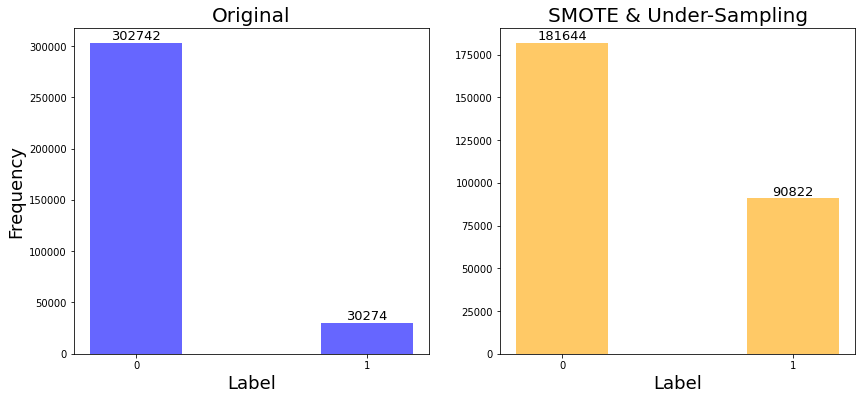

In [138]:
plt.figure(figsize=(14, 6))
plt.subplot(121)

# Plot the bar graph for the original train
Y_fraud = list(tr_df[y_var].value_counts())
Labels = ["0", "1"]

plot = plt.bar(Labels, Y_fraud, 
               width = 0.4,
              color = "blue",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("Original", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)


# After SMOTE & Random Undersampling transformation 
plt.subplot(122)

# Plot the bar graph for SMOTE & Undersampled train
Y_fraud = list(tr_y.value_counts())
X_fraud = ["0", "1"]

plot = plt.bar(X_fraud, Y_fraud, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("SMOTE & Under-Sampling", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
 
# Display the graph on the screen
plt.show()

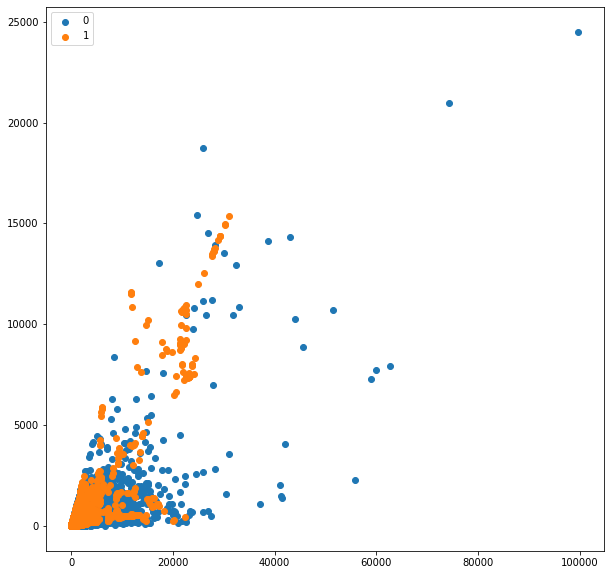

In [139]:
# scatter plot of the data transformed by SMOTE 
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_y)
for label, _ in counter.items():
    row_ix = where(tr_y == label)[0]
    plt.scatter(tr_X.iloc[row_ix, 3], tr_X.iloc[row_ix, 4], label=str(label))
plt.legend()
plt.show()

## Model Training 

### Data Partitioning (Train & Valid)

In [18]:
trans_tr_df = pd.concat([tr_X, tr_y], axis = 1)

In [19]:
# Split train and validation sets 
np.random.seed(SEED)

ratio = 0.8 # split train & validation sets with 7:3 ratio 

split = np.random.rand(len(trans_tr_df)) < ratio # define indices of 70% corresponding to the training set

train = trans_tr_df[split]
valid = trans_tr_df[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 363675, columns = 130
Validation data rows = 90438, columns = 130


## -------------XGBoost----------------

In [ ]:
#mono_constraints=None

#mono_constraints=mono_constraints

In [12]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

In [29]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7], 
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

#define monotonicity constraints
#train_corr_y = train[X_var + [y_var]].corr()[y_var].values[:-1]
#train_corr_y[np.isnan(train_corr_y)] = 1
#mono_constraints = tuple(int(i) for i in np.sign(train_corr_y))

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[X_var], train[y_var])
dvalid = xgb.DMatrix(valid[X_var], valid[y_var])

# Monotonic XGBoost grid search                        
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=20, ntree=1000, early_stopping_rounds=100, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/20:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1234, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.2}
Grid search new best score discovered at iteration 1/20: 0.9844.
---------- ----------
Grid search run 2/20:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1234, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.1}
---------- ----------
Grid search run 3/20:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1234, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'r

## Retrain XGBM on the entire data with the best hyperparameters 

In [116]:
from xgboost import XGBClassifier

params = {'booster': 'gbtree',
          'n_jobs': 4, 
          'n_estimators':1000,
          'objective': 'binary:logistic',
          'seed': 1234}
gs_params = {'colsample_bytree': 0.7,
             'colsample_bylevel': 0.9,
             'learning_rate': 0.5,
             'max_depth': 7, 
             'reg_alpha': 0.005,
             'reg_lambda': 0.005,
             'subsample': 0.9,
             'min_child_weight': 1, 
             'gamma': 0.2}


params.update(gs_params)

watchlist = [(train[X_var], train[y_var]), (valid[X_var], valid[y_var])]

model = XGBClassifier(**params)   
        
best_mxgb = model.fit(train[X_var], train[y_var],
                      early_stopping_rounds = 100,
                      eval_set = watchlist,
                      eval_metric='auc',
                      verbose=True)

[0]	validation_0-auc:0.69047	validation_1-auc:0.68932
[1]	validation_0-auc:0.73732	validation_1-auc:0.73752
[2]	validation_0-auc:0.79022	validation_1-auc:0.78794
[3]	validation_0-auc:0.79816	validation_1-auc:0.79566
[4]	validation_0-auc:0.83034	validation_1-auc:0.82792
[5]	validation_0-auc:0.84055	validation_1-auc:0.83866
[6]	validation_0-auc:0.84574	validation_1-auc:0.84365
[7]	validation_0-auc:0.85584	validation_1-auc:0.85387
[8]	validation_0-auc:0.86137	validation_1-auc:0.85898
[9]	validation_0-auc:0.87532	validation_1-auc:0.87264
[10]	validation_0-auc:0.88003	validation_1-auc:0.87674
[11]	validation_0-auc:0.88707	validation_1-auc:0.88408
[12]	validation_0-auc:0.89398	validation_1-auc:0.89061
[13]	validation_0-auc:0.90034	validation_1-auc:0.89688
[14]	validation_0-auc:0.90070	validation_1-auc:0.89730
[15]	validation_0-auc:0.90172	validation_1-auc:0.89772
[16]	validation_0-auc:0.90836	validation_1-auc:0.90449
[17]	validation_0-auc:0.91210	validation_1-auc:0.90814
[18]	validation_0-au

[149]	validation_0-auc:0.96779	validation_1-auc:0.95515
[150]	validation_0-auc:0.96788	validation_1-auc:0.95521
[151]	validation_0-auc:0.96800	validation_1-auc:0.95526
[152]	validation_0-auc:0.96817	validation_1-auc:0.95548
[153]	validation_0-auc:0.96825	validation_1-auc:0.95550
[154]	validation_0-auc:0.96840	validation_1-auc:0.95559
[155]	validation_0-auc:0.96891	validation_1-auc:0.95612
[156]	validation_0-auc:0.96898	validation_1-auc:0.95614
[157]	validation_0-auc:0.96915	validation_1-auc:0.95627
[158]	validation_0-auc:0.96925	validation_1-auc:0.95634
[159]	validation_0-auc:0.96937	validation_1-auc:0.95642
[160]	validation_0-auc:0.96939	validation_1-auc:0.95635
[161]	validation_0-auc:0.96947	validation_1-auc:0.95643
[162]	validation_0-auc:0.96970	validation_1-auc:0.95652
[163]	validation_0-auc:0.96972	validation_1-auc:0.95653
[164]	validation_0-auc:0.96981	validation_1-auc:0.95663
[165]	validation_0-auc:0.96995	validation_1-auc:0.95670
[166]	validation_0-auc:0.96997	validation_1-auc:

[296]	validation_0-auc:0.98082	validation_1-auc:0.96263
[297]	validation_0-auc:0.98093	validation_1-auc:0.96267
[298]	validation_0-auc:0.98103	validation_1-auc:0.96276
[299]	validation_0-auc:0.98103	validation_1-auc:0.96274
[300]	validation_0-auc:0.98110	validation_1-auc:0.96275
[301]	validation_0-auc:0.98118	validation_1-auc:0.96270
[302]	validation_0-auc:0.98124	validation_1-auc:0.96269
[303]	validation_0-auc:0.98127	validation_1-auc:0.96278
[304]	validation_0-auc:0.98141	validation_1-auc:0.96300
[305]	validation_0-auc:0.98154	validation_1-auc:0.96301
[306]	validation_0-auc:0.98157	validation_1-auc:0.96302
[307]	validation_0-auc:0.98162	validation_1-auc:0.96311
[308]	validation_0-auc:0.98168	validation_1-auc:0.96311
[309]	validation_0-auc:0.98170	validation_1-auc:0.96311
[310]	validation_0-auc:0.98184	validation_1-auc:0.96314
[311]	validation_0-auc:0.98191	validation_1-auc:0.96313
[312]	validation_0-auc:0.98198	validation_1-auc:0.96315
[313]	validation_0-auc:0.98204	validation_1-auc:

[443]	validation_0-auc:0.98790	validation_1-auc:0.96565
[444]	validation_0-auc:0.98793	validation_1-auc:0.96566
[445]	validation_0-auc:0.98801	validation_1-auc:0.96564
[446]	validation_0-auc:0.98803	validation_1-auc:0.96561
[447]	validation_0-auc:0.98807	validation_1-auc:0.96560
[448]	validation_0-auc:0.98812	validation_1-auc:0.96559
[449]	validation_0-auc:0.98819	validation_1-auc:0.96563
[450]	validation_0-auc:0.98823	validation_1-auc:0.96562
[451]	validation_0-auc:0.98827	validation_1-auc:0.96564
[452]	validation_0-auc:0.98830	validation_1-auc:0.96559
[453]	validation_0-auc:0.98833	validation_1-auc:0.96561
[454]	validation_0-auc:0.98835	validation_1-auc:0.96564
[455]	validation_0-auc:0.98839	validation_1-auc:0.96563
[456]	validation_0-auc:0.98849	validation_1-auc:0.96576
[457]	validation_0-auc:0.98855	validation_1-auc:0.96576
[458]	validation_0-auc:0.98861	validation_1-auc:0.96575
[459]	validation_0-auc:0.98864	validation_1-auc:0.96574
[460]	validation_0-auc:0.98869	validation_1-auc:

[590]	validation_0-auc:0.99237	validation_1-auc:0.96679
[591]	validation_0-auc:0.99238	validation_1-auc:0.96679
[592]	validation_0-auc:0.99240	validation_1-auc:0.96681
[593]	validation_0-auc:0.99242	validation_1-auc:0.96683
[594]	validation_0-auc:0.99245	validation_1-auc:0.96684
[595]	validation_0-auc:0.99245	validation_1-auc:0.96683
[596]	validation_0-auc:0.99248	validation_1-auc:0.96681
[597]	validation_0-auc:0.99251	validation_1-auc:0.96687
[598]	validation_0-auc:0.99252	validation_1-auc:0.96687
[599]	validation_0-auc:0.99254	validation_1-auc:0.96686
[600]	validation_0-auc:0.99256	validation_1-auc:0.96687
[601]	validation_0-auc:0.99258	validation_1-auc:0.96681
[602]	validation_0-auc:0.99261	validation_1-auc:0.96684
[603]	validation_0-auc:0.99265	validation_1-auc:0.96687
[604]	validation_0-auc:0.99267	validation_1-auc:0.96688
[605]	validation_0-auc:0.99270	validation_1-auc:0.96686
[606]	validation_0-auc:0.99273	validation_1-auc:0.96684
[607]	validation_0-auc:0.99277	validation_1-auc:

[737]	validation_0-auc:0.99532	validation_1-auc:0.96751
[738]	validation_0-auc:0.99533	validation_1-auc:0.96749
[739]	validation_0-auc:0.99533	validation_1-auc:0.96750
[740]	validation_0-auc:0.99536	validation_1-auc:0.96749
[741]	validation_0-auc:0.99538	validation_1-auc:0.96751
[742]	validation_0-auc:0.99539	validation_1-auc:0.96752
[743]	validation_0-auc:0.99540	validation_1-auc:0.96753
[744]	validation_0-auc:0.99543	validation_1-auc:0.96752
[745]	validation_0-auc:0.99544	validation_1-auc:0.96752
[746]	validation_0-auc:0.99544	validation_1-auc:0.96751
[747]	validation_0-auc:0.99546	validation_1-auc:0.96754
[748]	validation_0-auc:0.99547	validation_1-auc:0.96755
[749]	validation_0-auc:0.99549	validation_1-auc:0.96756
[750]	validation_0-auc:0.99550	validation_1-auc:0.96757
[751]	validation_0-auc:0.99550	validation_1-auc:0.96760
[752]	validation_0-auc:0.99553	validation_1-auc:0.96759
[753]	validation_0-auc:0.99555	validation_1-auc:0.96759
[754]	validation_0-auc:0.99556	validation_1-auc:

[884]	validation_0-auc:0.99709	validation_1-auc:0.96785
[885]	validation_0-auc:0.99710	validation_1-auc:0.96787
[886]	validation_0-auc:0.99711	validation_1-auc:0.96786
[887]	validation_0-auc:0.99712	validation_1-auc:0.96787
[888]	validation_0-auc:0.99712	validation_1-auc:0.96789
[889]	validation_0-auc:0.99713	validation_1-auc:0.96788
[890]	validation_0-auc:0.99714	validation_1-auc:0.96786
[891]	validation_0-auc:0.99714	validation_1-auc:0.96789
[892]	validation_0-auc:0.99715	validation_1-auc:0.96790
[893]	validation_0-auc:0.99715	validation_1-auc:0.96791
[894]	validation_0-auc:0.99716	validation_1-auc:0.96793
[895]	validation_0-auc:0.99717	validation_1-auc:0.96793
[896]	validation_0-auc:0.99718	validation_1-auc:0.96794
[897]	validation_0-auc:0.99719	validation_1-auc:0.96796
[898]	validation_0-auc:0.99720	validation_1-auc:0.96795
[899]	validation_0-auc:0.99720	validation_1-auc:0.96797
[900]	validation_0-auc:0.99721	validation_1-auc:0.96797
[901]	validation_0-auc:0.99721	validation_1-auc:

In [130]:
valid_eval = list(best_mxgb.evals_result().values())[1]
for key, value in valid_eval.items():
    print(f"best valid auc: {np.max(value)}")

best valid auc: 0.968165


In [141]:
best_mxgb_phat = pd.DataFrame(best_mxgb.predict_proba(te_df[X_var], iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat'])
best_mxgb_phat = pd.concat([te_df[X_var].reset_index(drop=True), best_mxgb_phat], axis=1)
best_mxgb_phat.head()

,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Type_Advanced Heart Failure and Transplant Cardiology,Type_All Other Suppliers,Type_Allergy/ Immunology,Type_Allergy/Immunology,...,Type_Thoracic Surgery,Type_Undefined Physician type,Type_Undersea and Hyperbaric Medicine,Type_Unknown Physician Specialty Code,Type_Unknown Supplier/Provider,Type_Unknown Supplier/Provider Specialty,Type_Urology,Type_Vascular Surgery,Place_Of_Srvc,phat
0,71,71.0,71,252.028169,77.456620,56.049155,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,55,108.0,108,209.000000,75.640648,56.665926,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19,19.0,19,168.100000,164.740000,164.740000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,85,95.0,95,105.000000,9.420000,9.420000,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,200,272.0,272,15.018382,2.897831,2.897831,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Find the best cutoff based on f1-score

In [165]:
from sklearn.metrics import f1_score,accuracy_score

def max_f1(x_test, y_test, res=0.01):
    pred_prob = best_mxgb.predict_proba(te_df[X_var], iteration_range=(0, best_mxgb.best_ntree_limit))
    phat_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["phat"])
    temp_df = pd.concat([te_df[["Fraud"]].reset_index(drop=True), phat_df],axis=1)
    
    f1_df = pd.DataFrame(columns = ["cut", "f1_score"])
    
    for cut in np.arange(0, 1+res, res):
        temp_df["pred"] = np.where(temp_df["phat"] > cut, 1, 0)
        f1 = f1_score(temp_df["Fraud"], temp_df["pred"])
        f1_df = f1_df.append({"cut":cut, 
                              "f1_score":f1}, 
                             ignore_index=True)
        
    max_f1 = f1_df.loc[f1_df["f1_score"] == f1_df["f1_score"].max()]
    return max_f1

max_f1 = max_f1(x_test, y_test)
max_f1

,cut,f1_score
22,0.22,0.415143


In [166]:
import pickle

with open("fraud_mxgb.pkl", "wb") as file:
    pickle.dump(best_mxgb, file)